# Load model and signal processing functions

In [63]:
import pickle as pkl

#Load the data
with open('model.pkl', 'rb') as file:
    pipe, lbenc = pkl.load(file)

In [46]:
#Read audio data from files
#Using ffmpeg

import numpy as np
import subprocess as sp
import librosa

duration = 30

def get_waveform(filename, mono=True, duration=30, delay=0, sr=22050):
    if mono:
        n_channels = 1
    else:
        n_channels = 2 # n_channels: 2 for stereo, 1 for mono
    
    command = [ 'ffmpeg',
            '-i', filename,
            '-f', 's16le',
            '-ss', str(delay),
            '-t', str(duration),
            '-acodec', 'pcm_s16le',
            '-ar', str(sr),
            '-ac', str(n_channels),
            '-']
    proc = sp.run(command, stdout=sp.PIPE, bufsize=duration*sr, stderr=None, check=False) #stderr=sp.DEVNULL
    audio_array = np.fromstring(proc.stdout, dtype="int16")
    
    audio_array = librosa.util.normalize(audio_array)
    
    return audio_array, sr

In [47]:
from librosa.effects import harmonic
from librosa.effects import hpss
from librosa.feature import spectral_contrast
from scipy.stats import skew, kurtosis

#Generate the Feature vector

#Harmonic-Percussive Source Separation
def get_harm(data, n=13):
    y_harm, y_perc = hpss(data)
    return np.concatenate((get_mfcc(y_harm, n), get_mfcc(y_perc, n), get_spect(data)))

#MFCC
def get_mfcc(data, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=n_mfcc, n_fft = 2048, hop_length=512, n_mels=40, power=2.0)
    
    mean = np.mean(mfcc, axis=1)
    var = np.std(mfcc, axis=1)
    
    derv = np.gradient(mfcc, axis=1)
    derv2 = np.gradient(derv, axis=1)
    
    derv_mean = np.mean(derv,axis=1)
    derv_var = np.std(derv,axis=1)
    
    derv2_mean = np.mean(derv2,axis=1)
    derv2_var = np.std(derv2,axis=1)
    
    ret = np.concatenate((mean,var,derv_mean, derv_var, derv2_mean, derv2_var))
    return ret

#Spectral contrast
def get_spect(data):
    spec_cont = spectral_contrast(data)
    
    mean = np.mean(spec_cont,axis=1)
    var = np.std(spec_cont, axis=1)
    
    derv = np.gradient(spec_cont, axis=1)
    derv2 = np.gradient(derv, axis=1)
    
    derv_mean = np.mean(derv,axis=1)
    derv_var = np.std(derv,axis=1)
    
    derv2_mean = np.mean(derv2,axis=1)
    derv2_var = np.std(derv2,axis=1)
    
    ret = np.concatenate((mean,var,derv_mean, derv_var, derv2_mean, derv2_var, \
                          skew(spec_cont, axis=1), kurtosis(spec_cont, axis=1)))
    return ret

# Plot predictions

(0, 0.8)

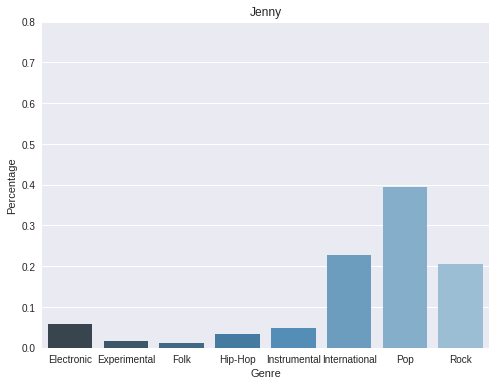

In [75]:
# Predict top genres for a song

filename = 'songs/Jenny.mp3'

tags = {}

delay = 150
a, sr = get_waveform(filename, mono=True, duration=30, delay=delay, sr=22050)
# feed it into the signal processing pipeline to get a feature vector
vec = get_harm(a).reshape(1,-1)

# run predictions on the feature vector
for i, score in enumerate(pipe.predict_proba(vec)[0]):
    tags[lbenc.inverse_transform(i)] = score

vals = [(key, val) for key, val in tags.items()]

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

v1,v2 = zip(*vals)

plt.figure(figsize=(8, 6))
g = sns.barplot(x=v1, y=v2, palette="Blues_d")
g.set_xticklabels(labels=v1, rotation=0);
g.set_ylabel('Percentage')
g.set_xlabel('Genre')
g.set_title('Jenny')
plt.ylim([0,0.8])